# Run a Periodogram Across Full ZTF Sources

This notebook is an adaptation of the Nested Dask [tutorial for loading HiPSCat data](https://nested-dask.readthedocs.io/en/latest/tutorials/work_with_lsdb.html).

## Install dependencies for the notebook

The notebook requires few packages to be installed.
- `lsdb` to load and join "object" (pointing) and "source" (detection) ZTF catalogs
- `aiohttp` is `lsdb`'s optional dependency to download the data via web
- `light-curve` to extract features from light curves
- `matplotlib` to plot the results

In [1]:
# Comment the following lines to skip dependencies installation
%pip install --quiet -U hats lsdb
%pip install --quiet light-curve matplotlib tqdm memray

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import sys
import time
from importlib.metadata import version
from tempfile import TemporaryDirectory

import light_curve as licu
import matplotlib.pyplot as plt
import memray
import numpy as np
from lsdb import read_hats
from lsdb.core.search.pixel_search import PixelSearch
from tqdm.auto import tqdm
from upath import UPath

In [2]:
print(f"{version('lsdb') = }")
print(f"{version('nested-dask') = }")
print(f"{version('dask') = }")
print(f"{version('dask-expr') = }")

version('lsdb') = '0.4.3'
version('nested-dask') = '0.3.0'
version('dask') = '2024.8.2'
version('dask-expr') = '1.1.13'


Some additional setup for using Dask on PSC Bridges2:

## Load ZTF DR14

In [22]:
def get_nested_catalog(search_area):
    catalogs_dir = UPath("https://data.lsdb.io/hats/ztf_dr14/")


    lsdb_object = read_hats(
        catalogs_dir / "ztf_object",
        columns=["ra", "dec", "ps1_objid"],
        search_filter=search_area,
    )
    lsdb_source = read_hats(
        catalogs_dir / "ztf_source",
        columns=["mjd", "ra", "dec", "mag", "magerr", "band", "ps1_objid", "catflags"],
        search_filter=search_area,
    )
    lc_columns = ["mjd", "mag", "magerr", "band", "catflags"]
    
    nested = lsdb_object.join_nested(lsdb_source, left_on="ps1_objid", right_on="ps1_objid", nested_column_name="lc")
    return nested


def get_large_r_band(catalog):
    r_band = catalog.query("lc.catflags == 0 and lc.band == 'r'")
    nobs = r_band.reduce(lambda mjd: {"nobs": np.size}, "lc.mjd", meta={"nobs": int})
    r_band = r_band[nobs["nobs"] > 10]
    return r_band


extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        max_freq_factor=1.0, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=True,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


def get_features(catalog):
    return catalog.reduce(
        extract_features,
        "lc.mjd",
        "lc.mag",
        meta={name: np.float32 for name in extractor.names},
    )


def measure_dask_graph(search_area):
    nested = get_nested_catalog(search_area)
    r_band = get_large_r_band(nested)
    features = get_features(r_band)
    mean_period = features['period_0'].mean()
    
    with TemporaryDirectory() as temp_dir:
        temp_file = UPath(temp_dir) / "memray.bin"
        with memray.Tracker(temp_file) as tracer:
            t0 = time.monotonic()
            graph = mean_period.dask
            dt = time.monotonic() - t0
        memray_file = memray.FileReader(temp_file)
        peak_memory = memray_file.metadata.peak_memory
    
    n_tasks = len(graph)
    sizeof = sys.getsizeof(graph)
    
    return {
        "partitions": nested._ddf.npartitions,
        "tasks": n_tasks,
        "time": dt,
        "sizeof": sizeof,
        "peak_memory": peak_memory,
    }

In [27]:
# search_area = None
order = 1

results = {}
for n_pix in tqdm([1, 2, 3, 4, 6, 8, 16, 32, 48]):
    search_area = PixelSearch([(order, i_pix) for i_pix in range(n_pix)])
    result = measure_dask_graph(search_area)
    print(n_pix, result)
    results[n_pix] = result

  0%|          | 0/9 [00:00<?, ?it/s]/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 11%|█         | 1/9 [00:06<00:52,  6.56s/it]

1 {'partitions': 277, 'tasks': 4183, 'time': 0.10567649500444531, 'sizeof': 147544, 'peak_memory': 2645881}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 22%|██▏       | 2/9 [00:15<00:55,  7.87s/it]

2 {'partitions': 1475, 'tasks': 22223, 'time': 1.1970709897577763, 'sizeof': 1310800, 'peak_memory': 196443281}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 33%|███▎      | 3/9 [00:26<00:57,  9.51s/it]

3 {'partitions': 2847, 'tasks': 42882, 'time': 3.7150724590756, 'sizeof': 1310800, 'peak_memory': 377477713}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 44%|████▍     | 4/9 [00:44<01:02, 12.59s/it]

4 {'partitions': 4468, 'tasks': 67294, 'time': 7.939565933775157, 'sizeof': 2621528, 'peak_memory': 599383541}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 56%|█████▌    | 5/9 [01:04<01:02, 15.56s/it]

6 {'partitions': 5031, 'tasks': 75786, 'time': 10.874828859698027, 'sizeof': 2621528, 'peak_memory': 2655612145}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 67%|██████▋   | 6/9 [01:30<00:57, 19.08s/it]

8 {'partitions': 6086, 'tasks': 91685, 'time': 15.15534384129569, 'sizeof': 5242960, 'peak_memory': 3221350401}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 78%|███████▊  | 7/9 [05:08<02:47, 83.90s/it]

16 {'partitions': 22291, 'tasks': 335458, 'time': 189.0873250006698, 'sizeof': 10485848, 'peak_memory': 46905346437}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
 89%|████████▉ | 8/9 [15:50<04:21, 261.60s/it]

32 {'partitions': 40489, 'tasks': 609496, 'time': 593.8314248840325, 'sizeof': 20971600, 'peak_memory': 85191401325}


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
100%|██████████| 9/9 [27:52<00:00, 185.86s/it]

48 {'partitions': 41679, 'tasks': 627540, 'time': 675.0943748727441, 'sizeof': 20971600, 'peak_memory': 87691108157}


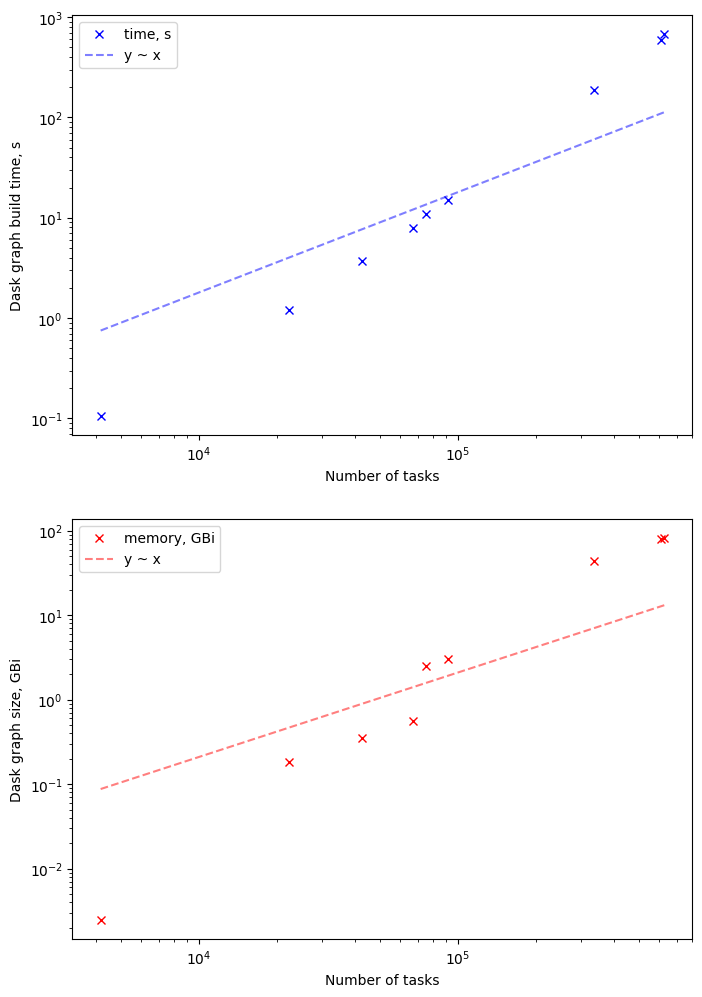

In [28]:
array_names = list(next(iter(results.values())).keys())
arrays = {key: np.array([inner_dict[key] for inner_dict in results.values()])
          for key in array_names}

fig, ax = plt.subplots(2, figsize=(8, 12))

x_ = np.geomspace(arrays["tasks"].min(), arrays["tasks"].max(), 100)

y_ = x_ * np.exp(np.mean(np.log(arrays["time"]) - np.log(arrays["tasks"])))
ax[0].set_xlabel("Number of tasks")
ax[0].set_xscale("log")
ax[0].set_ylabel("Dask graph build time, s")
ax[0].set_yscale("log")
ax[0].plot(arrays["tasks"], arrays["time"], "x", color="blue", label="time, s")
ax[0].plot(x_, y_, '--', color="blue", alpha=0.5, label="y ~ x")
ax[0].legend()

ram_gb = arrays["peak_memory"] / (1 << 30)
y_ = x_ * np.exp(np.mean(np.log(ram_gb) - np.log(arrays["tasks"])))
ax[1].set_xlabel("Number of tasks")
ax[1].set_xscale("log")
ax[1].set_ylabel("Dask graph size, GBi")
ax[1].set_yscale("log")
ax[1].plot(arrays["tasks"], ram_gb, 'x', color='red', label='memory, GBi')
ax[1].plot(x_, y_, '--', color="red", alpha=0.5, label="y ~ x")
ax[1].legend()

fig.savefig("dask_graph_scaling-tasks.png")

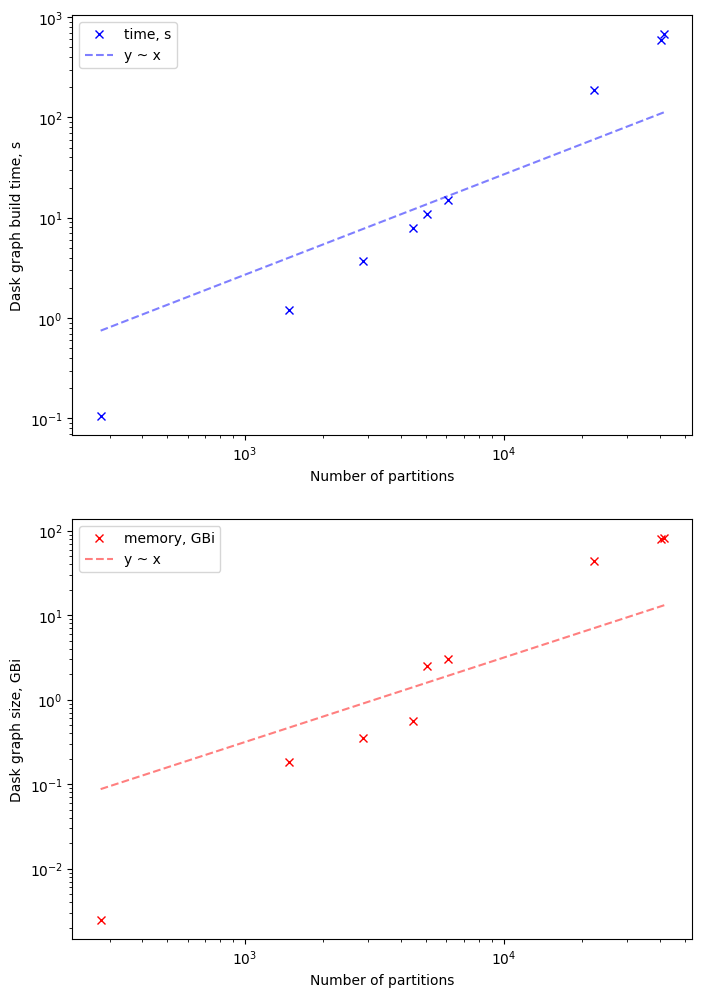

In [29]:
fig, ax = plt.subplots(2, figsize=(8, 12))

x_ = np.geomspace(arrays["partitions"].min(), arrays["partitions"].max(), 100)

y_ = x_ * np.exp(np.mean(np.log(arrays["time"]) - np.log(arrays["partitions"])))
ax[0].set_xlabel("Number of partitions")
ax[0].set_xscale("log")
ax[0].set_ylabel("Dask graph build time, s")
ax[0].set_yscale("log")
ax[0].plot(arrays["partitions"], arrays["time"], "x", color="blue", label="time, s")
ax[0].plot(x_, y_, '--', color="blue", alpha=0.5, label="y ~ x")
ax[0].legend()

ram_gb = arrays["peak_memory"] / (1 << 30)
y_ = x_ * np.exp(np.mean(np.log(ram_gb) - np.log(arrays["partitions"])))
ax[1].set_xlabel("Number of partitions")
ax[1].set_xscale("log")
ax[1].set_ylabel("Dask graph size, GBi")
ax[1].set_yscale("log")
ax[1].plot(arrays["partitions"], ram_gb, 'x', color='red', label='memory, GBi')
ax[1].plot(x_, y_, '--', color="red", alpha=0.5, label="y ~ x")
ax[1].legend()

fig.savefig("dask_graph_scaling-partitions.png")